<a href="https://colab.research.google.com/github/kiptuidenis/Tomato-Disease-Detection/blob/main/tomato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato Disease Classification using CNN

This notebook builds a Convolutional Neural Network (CNN) to classify images of tomato leaves into different disease categories. It also includes the capability to identify images that are not tomato leaves.

## 1. Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil # For creating a 'non_tomato' class if needed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load and Preprocess the Dataset

In [3]:
# Define paths and parameters
base_dir = '/content/drive/MyDrive/Tomatoes'
image_height = 128
image_width = 128
batch_size = 32

# Image Data Generators with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Splitting 20% of the data for validation
)

# For the validation/test set, we only rescale
# Note: It's better to have a separate test_datagen if test set augmentation differs or is not desired.
# For simplicity here, validation_generator will use the same augmentation settings as train_datagen (excluding validation_split part)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Also applying validation_split here to ensure it picks up the correct subset

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training', # Set as training data
    # Add a seed for reproducibility if desired
    # seed=42
)

# Flow validation images in batches using the same train_datagen instance but with subset='validation'
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', # Set as validation data
    # seed=42 # Use the same seed if you want consistent split
)


# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Found {train_generator.samples} images belonging to {num_classes} classes for training.")
print(f"Found {validation_generator.samples} images belonging to {num_classes} classes for validation.")
print("Classes:", class_names)

# Handling 'not tomato leaves'
# Create a 'non_tomato' directory if it doesn't exist.
# You MUST populate this directory with images that are NOT tomato leaves for the model to learn this category.
non_tomato_dir = os.path.join(base_dir, 'non_tomato')
if not os.path.exists(non_tomato_dir):
    os.makedirs(non_tomato_dir)
    print(f"Created directory: {non_tomato_dir}. Please add non-tomato images to this folder and re-run data loading.")
    # IMPORTANT: After adding images to 'non_tomato', you need to re-run the cell above that defines
    # train_generator and validation_generator so they can pick up the new class.
    # If 'non_tomato' remains empty, the model won't learn to classify them.

# After potentially adding the 'non_tomato' class and its images,
# it's crucial to re-initialize the ImageDataGenerators to include this new class.
# For this initial run, if 'non_tomato' was just created and is empty,
# the class_names and num_classes will reflect only the original folders.
# The user needs to add images and re-run the ImageDataGenerator cells.

Found 1305 images belonging to 6 classes.
Found 324 images belonging to 6 classes.
Found 1305 images belonging to 6 classes for training.
Found 324 images belonging to 6 classes for validation.
Classes: ['Aug_bacterial_spot', 'Aug_early_blight', 'Aug_leaf_mould', 'Aug_others', 'Aug_tuta_absoluta', 'Aug_white_flies']
Created directory: /content/drive/MyDrive/Tomatoes/non_tomato. Please add non-tomato images to this folder and re-run data loading.


## 3. Visualize the Dataset

Sample Training Images:


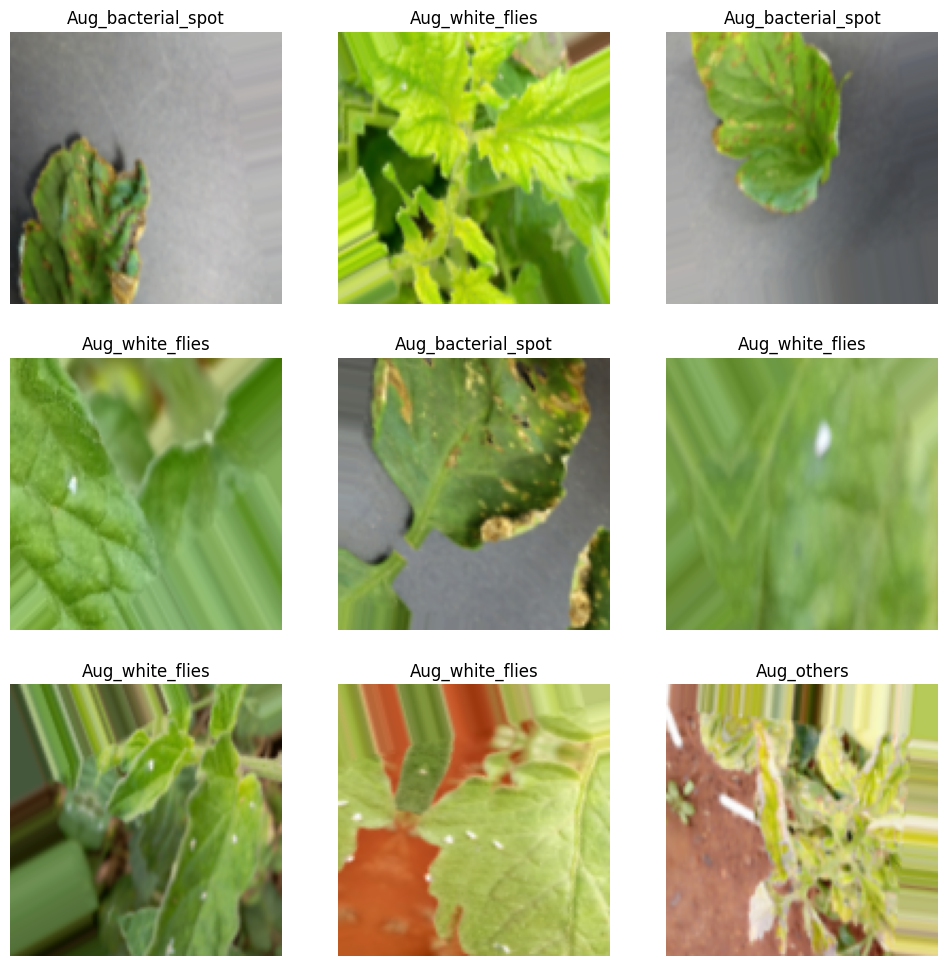


Sample Validation Images:


In [ ]:
def plot_sample_images(generator, class_names_list):
    images, labels = next(generator) # Get a batch of images and labels
    plt.figure(figsize=(12, 12))
    for i in range(min(9, len(images))): # Display up to 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # Ensure class_names_list is correctly indexed
        try:
            plt.title(class_names_list[np.argmax(labels[i])])
        except IndexError:
            plt.title("Unknown Class") # Fallback if index is out of bounds
        plt.axis("off")
    plt.show()

# Ensure class_names is up-to-date after potential 'non_tomato' addition and re-run of generators
current_class_names = list(train_generator.class_indices.keys())

print("Sample Training Images:")
plot_sample_images(train_generator, current_class_names)

print("\nSample Validation Images:")
plot_sample_images(validation_generator, current_class_names)

## 4. Build the CNN Model

In [ ]:
# Ensure num_classes is updated if 'non_tomato' class was added and generators were re-run
current_num_classes = len(train_generator.class_indices)

model = Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), # Dropout for regularization
    layers.Dense(current_num_classes, activation='softmax') # Output layer: num_classes neurons for multi-class classification
])

model.summary()

## 5. Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6. Train the Model

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)

epochs = 10 # Adjust as needed

# Check if generators are empty (can happen if paths are wrong or no images found)
if train_generator.samples == 0:
    print("Error: Training generator is empty. Check dataset paths and image files.")
elif validation_generator.samples == 0:
    print("Error: Validation generator is empty. Check dataset paths and image files or validation_split.")
else:
    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // batch_size), # Ensure steps_per_epoch is at least 1
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // batch_size), # Ensure validation_steps is at least 1
        callbacks=[early_stopping, reduce_lr]
    )
    print("Model training finished.")

## 7. Evaluate the Model

In [ ]:
if 'history' in locals() and history is not None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Evaluate on the validation set (acting as a test set for now)
    print("\nEvaluating model on validation data...")
    if validation_generator.samples > 0:
        val_loss_eval, val_acc_eval = model.evaluate(validation_generator, steps=max(1, validation_generator.samples // batch_size))
        print(f"Validation Loss: {val_loss_eval}")
        print(f"Validation Accuracy: {val_acc_eval}")
    else:
        print("Validation generator is empty, cannot evaluate.")
else:
    print("Model was not trained (history object not found). Skipping evaluation plots.")

# Note: For a proper final evaluation, you should use a separate, unseen test set.
# Create a test_generator similar to train_generator and validation_generator, pointing to a 'test' directory.
# test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_acc}")

## 8. Test with New Images

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model_to_test, class_names_list, img_height, img_width, non_tomato_confidence_threshold=0.5):
    if not os.path.exists(img_path):
        print(f"Error: Image path not found: {img_path}")
        return None, None

    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch
    img_array /= 255. # Rescale

    predictions = model_to_test.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    predicted_class_name = class_names_list[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')

    # Logic for 'not tomato leaf' detection
    # This is more effective if 'non_tomato' is a trained class.
    if 'non_tomato' in class_names_list and predicted_class_name == 'non_tomato':
        title_text = f"Predicted: Not a Tomato Leaf (as 'non_tomato' class)\nConfidence: {confidence*100:.2f}%"
    elif confidence < non_tomato_confidence_threshold and 'non_tomato' not in class_names_list:
        # If 'non_tomato' is not a class, use threshold for other classes
        title_text = f"Predicted: Unsure / Likely Not Tomato Leaf\n(Low confidence: {confidence*100:.2f}% for {predicted_class_name})"
        predicted_class_name = "Unknown/Non-Tomato (Low Confidence)"
    elif confidence < non_tomato_confidence_threshold and predicted_class_name != 'non_tomato' and 'non_tomato' in class_names_list:
        # If 'non_tomato' IS a class, but another class has low confidence
        title_text = f"Predicted: {predicted_class_name} (Low Confidence: {confidence*100:.2f}%)\nConsider if it might be 'non_tomato'."
    else:
        title_text = f"Predicted: {predicted_class_name}\nConfidence: {confidence*100:.2f}%"

    plt.title(title_text)
    plt.show()

    print(title_text.replace('\n', ' '))
    return predicted_class_name, confidence

# --- Example Usage (Replace with your actual image paths!) ---
# Ensure class_names is up-to-date
current_class_names_for_prediction = list(train_generator.class_indices.keys())

# Path to an image from your 'healthy' class
# IMPORTANT: Replace this with an actual path to one of your healthy tomato leaf images.
dummy_healthy_img_path = os.path.join(base_dir, 'healthy', '0a0d5a74-bb60-418a-94fd-8f7d80101589___GH_HL Leaf 193.JPG')

# Path to an image that is NOT a tomato leaf
# IMPORTANT: Replace this with an actual path to an image that is not a tomato leaf.
# For example, an image of a car, a cat, a different plant, or place it in the 'non_tomato' folder and test.
dummy_non_tomato_img_path = os.path.join(base_dir, 'non_tomato', 'test_non_tomato_image.jpg') # Create this file or use another

# Create a dummy non-tomato image if it doesn't exist for testing purposes
if not os.path.exists(dummy_non_tomato_img_path) and not os.path.exists(os.path.join(base_dir, 'non_tomato')):
    # Simple placeholder if no non_tomato image is available
    try:
        # Create a simple black image as a placeholder if Pillow is installed
        from PIL import Image
        img_placeholder = Image.new('RGB', (image_width, image_height), color = 'black')
        # Ensure the 'non_tomato' directory exists before saving
        if not os.path.exists(os.path.join(base_dir, 'non_tomato')):
            os.makedirs(os.path.join(base_dir, 'non_tomato'))
        dummy_non_tomato_img_path = os.path.join(base_dir, 'non_tomato', 'placeholder_non_tomato.png')
        img_placeholder.save(dummy_non_tomato_img_path)
        print(f"Created a placeholder non-tomato image: {dummy_non_tomato_img_path}")
    except ImportError:
        print("Pillow library not found, cannot create placeholder non-tomato image. Please provide one manually.")
        dummy_non_tomato_img_path = None # Set to None if cannot create
    except Exception as e:
        print(f"Error creating placeholder image: {e}")
        dummy_non_tomato_img_path = None

if 'model' in locals(): # Check if model is trained/defined
    print("\n--- Testing with a Healthy Tomato Image ---")
    if os.path.exists(dummy_healthy_img_path):
        predict_image(dummy_healthy_img_path, model, current_class_names_for_prediction, image_height, image_width, non_tomato_confidence_threshold=0.6)
    else:
        print(f"Test image not found: {dummy_healthy_img_path}. Please provide a valid path.")

    print("\n--- Testing with a Non-Tomato Image ---")
    if dummy_non_tomato_img_path and os.path.exists(dummy_non_tomato_img_path):
        predict_image(dummy_non_tomato_img_path, model, current_class_names_for_prediction, image_height, image_width, non_tomato_confidence_threshold=0.6)
    elif not dummy_non_tomato_img_path:
        print("Skipping non-tomato image test as placeholder could not be created and no path was provided.")
    else:
        print(f"Test image not found: {dummy_non_tomato_img_path}. Please provide a valid path to a non-tomato image (or ensure the placeholder was created).")

    # Example: Test with an image from one of the disease classes
    # dummy_disease_img_path = os.path.join(base_dir, 'Aug_bacterial_spot', 'aug_0_8655.png') # Replace with actual image
    # print("\n--- Testing with a Diseased Tomato Image ---")
    # if os.path.exists(dummy_disease_img_path):
    #     predict_image(dummy_disease_img_path, model, current_class_names_for_prediction, image_height, image_width)
    # else:
    #     print(f"Test image not found: {dummy_disease_img_path}. Please provide a valid path.")
else:
    print("Model not defined or trained. Skipping tests with new images.")

print("\nReminder: For best 'not tomato leaf' detection, train the model with a dedicated 'non_tomato' class containing diverse examples.")

## 9. Save and Load the Model

In [ ]:
if 'model' in locals():
    model_save_path = os.path.join(base_dir, 'tomato_disease_cnn_model.h5')
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Example of loading the model:
    # loaded_model = keras.models.load_model(model_save_path)
    # print(f"Model loaded from {model_save_path}")

    # You can then use loaded_model to make predictions:
    # if os.path.exists(dummy_healthy_img_path):
    #     print("\n--- Testing Loaded Model with a Healthy Tomato Image ---")
    #     predict_image(dummy_healthy_img_path, loaded_model, current_class_names_for_prediction, image_height, image_width)
    # else:
    #     print(f"Test image not found: {dummy_healthy_img_path} for loaded model test.")
else:
    print("Model not defined. Skipping model saving.")

In [ ]:
import tensorflow as tf
import os

# Define the path to the saved Keras model
# This should be the same path where you saved your trained model
base_dir = '/content/drive/MyDrive/Tomatoes'
keras_model_path = os.path.join(base_dir, 'tomato_disease_cnn_model.h5')

# Define the path for the TFLite model
tflite_model_path = os.path.join(base_dir, 'tomato_disease_model.tflite')

# Check if the Keras model file exists
if not os.path.exists(keras_model_path):
    print(f"ERROR: Saved Keras model not found at {keras_model_path}")
    print("Please ensure you have trained and saved the model in the previous steps.")
else:
    print(f"Loading Keras model from: {keras_model_path}")
    # Load the Keras model
    try:
        model = tf.keras.models.load_model(keras_model_path)
        print("Keras model loaded successfully.")

        # Convert the model to TensorFlow Lite format
        converter = tf.lite.TFLiteConverter.from_keras_model(model)

        # You can enable optimizations if needed. For example, default optimizations:
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # For more control over quantization (e.g., float16 or int8),
        # you would add more configurations here. For example:
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # converter.target_spec.supported_types = [tf.float16] # For float16 quantization

        tflite_model = converter.convert()
        print("Model converted to TensorFlow Lite format successfully.")

        # Save the TFLite model to a file
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TensorFlow Lite model saved to: {tflite_model_path}")
        print(f"Size of TFLite model: {os.path.getsize(tflite_model_path) / (1024):.2f} KB")

    except Exception as e:
        print(f"An error occurred during model loading or conversion: {e}")